# 2. Neural Network Classification with PyTorch

Binary, multi-class, or multi-label classification

1. Binary: Either this or that
2. Multi-class: One out of multiple options
3. Multi-label: One data point can have multiple labels assigned to it

In [94]:
import sklearn
from sklearn.datasets import make_circles

In [95]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [96]:
len(X), len(y)

(1000, 1000)

In [97]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [98]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [99]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

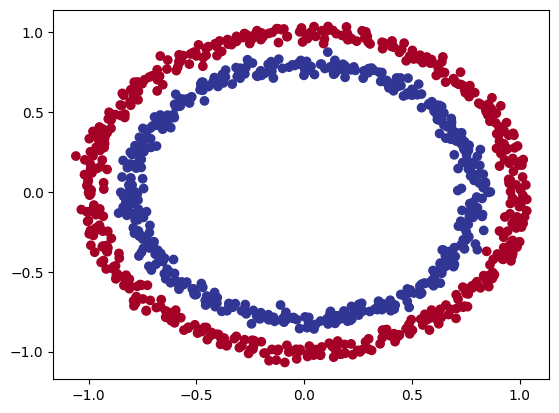

In [100]:
# Visualize the data
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

**Note:** The dataset here is a "toy dataset"; small enough to experiment with but sizeable enough to practice the fundamentals on.

## 1. Set up the data

### 1.1 Check input and output shapes

In [101]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Separate into train and test tensors

In [102]:
import torch
from torch import nn
torch.__version__

'2.9.1+cu130'

In [103]:
type(X), X.dtype, y.dtype

(numpy.ndarray, dtype('float64'), dtype('int64'))

In [104]:
# Turn into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [105]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [106]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
len(X_train), len(X_test), type(X_train)

(800, 200, torch.Tensor)

## 2. Building a model

1. Set up device agnostic code
2. Construct a model (subclass `nn.Module`)
3. Define loss function and optimizer
4. Create training and testing loops

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [109]:
X_train, X_test = X_train.to(device), X_test.to(device)

In [110]:
y_train, y_test = y_train.to(device), y_test.to(device)

### 2.1 Create the model

1. Create 2 `nn.Linear()` layers capable of handling the shapes of our data
2. Define `forward()` method
3. Instanitate our model class and send to target device

In [112]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer_1 = nn.Linear(in_features=2, out_features=5, device=device)
        # self.layer_2 = nn.Linear(in_features=5, out_features=1, device=device)
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        ).to(device=device)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # return self.layer_2(self.layer_1(X))
        return self.two_linear_layers(X)
    
model_0 = CircleModelV0().to(device=device)
model_0, model_0.state_dict()

(CircleModelV0(
   (two_linear_layers): Sequential(
     (0): Linear(in_features=2, out_features=5, bias=True)
     (1): Linear(in_features=5, out_features=1, bias=True)
   )
 ),
 OrderedDict([('two_linear_layers.0.weight',
               tensor([[-0.3478, -0.1711],
                       [-0.4800,  0.6430],
                       [-0.0732,  0.6866],
                       [ 0.5937, -0.6349],
                       [ 0.0264,  0.6039]], device='cuda:0')),
              ('two_linear_layers.0.bias',
               tensor([ 0.2470,  0.6816, -0.4644, -0.4022,  0.0228], device='cuda:0')),
              ('two_linear_layers.1.weight',
               tensor([[ 0.0660, -0.4327,  0.4155, -0.3199,  0.2176]], device='cuda:0')),
              ('two_linear_layers.1.bias',
               tensor([-0.2861], device='cuda:0'))]))

In [113]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [114]:
# # Same model can be created jsut by using nn.Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device=device)

In [115]:
# model_0, model_0.state_dict()

In [116]:
# next(model_0.parameters()).device

### 2.2 Set up loss function and optimizer

For classification, `nn.L1Loss()` (Mean Absolute Error) or Mean Squared Error will not work since it is for linear regression

For classification, we might need **Binary or Categorical Cross Entropy**

For optimizers, SGD and Adam are the most useful, but there are others too

In [117]:
# Set up the loss function

loss_fn = nn.BCEWithLogitsLoss() # has Sigmoid activation function built-in
# nn.BCELoss() requires inputs to have gone through sigmoid activation before being fed into it

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [118]:
# Calculate accuracy - TP/(TP+TN) How many are correctly predicted
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Train model

Training loop:

1. Set up training mode
2. Forward pass on data
3. Calculate loss
4. Zero gradients on optimizer
5. Backpropagation on loss
6. Step the optimizer (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Model outputs are raw **logits**. Can convert them into **prediction probabilities** by passing them into an **activation function** (e.g. sigmoid, softmax).

Then convert the prediction probabilities to **prediction labels** by rounding them or taking the `argmax()` (for binary and categorical respectively).

In [119]:
# Raw logit output
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.3874],
        [-0.3074],
        [-0.7070],
        [-0.2964],
        [-0.8817]], device='cuda:0')

In [120]:
# Use the sigmoid activation function on logits to to turn them into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4043],
        [0.4237],
        [0.3303],
        [0.4264],
        [0.2928]], device='cuda:0')

In [121]:
y_preds = torch.round(y_pred_probs)

# Complete flow
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test[:5])))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.2 Building training and testing loops

In [122]:
epochs = 100

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calc loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects logits, BCELoss expects torch.sigmoid(y_logits)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ## Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.74532, Acc: 50.00 | Test loss: 0.74459, Test acc: 50.00
Epoch: 10 | Loss: 0.71316, Acc: 50.00 | Test loss: 0.71638, Test acc: 50.00
Epoch: 20 | Loss: 0.70229, Acc: 45.38 | Test loss: 0.70643, Test acc: 39.50
Epoch: 30 | Loss: 0.69799, Acc: 47.88 | Test loss: 0.70210, Test acc: 47.00
Epoch: 40 | Loss: 0.69598, Acc: 48.00 | Test loss: 0.69976, Test acc: 49.00
Epoch: 50 | Loss: 0.69490, Acc: 48.62 | Test loss: 0.69827, Test acc: 49.00
Epoch: 60 | Loss: 0.69426, Acc: 48.75 | Test loss: 0.69724, Test acc: 49.00
Epoch: 70 | Loss: 0.69385, Acc: 49.38 | Test loss: 0.69650, Test acc: 49.50
Epoch: 80 | Loss: 0.69359, Acc: 49.38 | Test loss: 0.69594, Test acc: 50.00
Epoch: 90 | Loss: 0.69341, Acc: 49.62 | Test loss: 0.69553, Test acc: 50.00


## 4. Make predictions and evaluate the model

In [123]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


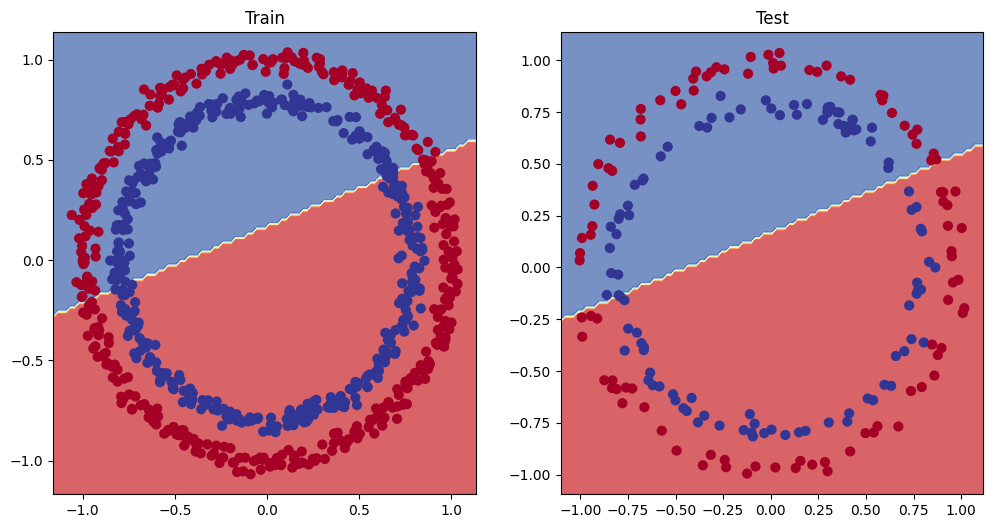

In [124]:
# Plot precision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model

* Add more layers - more chance to learn about patterns in the data
* Add more hidden units
* Train for more epochs
* Change the activation function
* Change the learning rate
* Change the loss function

These are changes we can make **to the model**.

Since these values can be changed by the **experimentor**, these are called hyperparameters.

Change hyperparameters **one by one** so we can track which changes have what effect

In [125]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Linear(in_features=10, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        ).to(device=device)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)
    
model_1 = CircleModelV1().to(device=device)
model_1, model_1.state_dict()

(CircleModelV1(
   (layers): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): Linear(in_features=10, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=1, bias=True)
   )
 ),
 OrderedDict([('layers.0.weight',
               tensor([[ 0.4134, -0.1451],
                       [-0.0189,  0.3435],
                       [-0.6049,  0.2230],
                       [ 0.3686,  0.1567],
                       [-0.6815, -0.2299],
                       [ 0.2661, -0.1976],
                       [-0.5216,  0.5889],
                       [-0.0142, -0.2840],
                       [ 0.4352,  0.1259],
                       [-0.6558, -0.4703]], device='cuda:0')),
              ('layers.0.bias',
               tensor([ 0.1036, -0.0695, -0.6534, -0.0796, -0.0748, -0.6999, -0.6725, -0.5081,
                       -0.2782, -0.4674], device='cuda:0')),
              ('layers.1.weight',
               tensor([[ 0.1713, -0.2891, -0.2210, -0.1636,  0.

In [126]:
# Set up the loss function

loss_fn = nn.BCEWithLogitsLoss() # has Sigmoid activation function built-in
# nn.BCELoss() requires inputs to have gone through sigmoid activation before being fed into it

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [131]:
epochs = 1000

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calc loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects logits, BCELoss expects torch.sigmoid(y_logits)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 100 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 200 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 300 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 400 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 500 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 800 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epoch: 900 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00


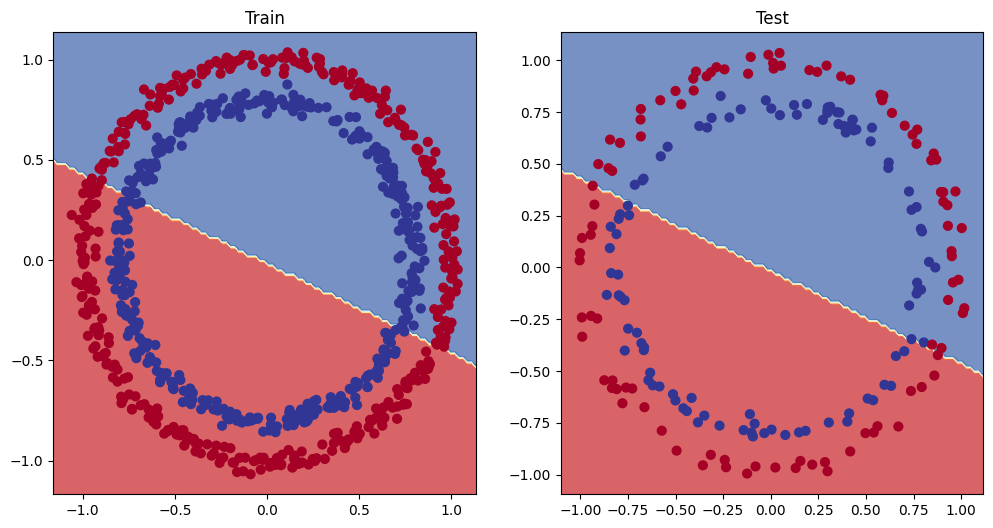

In [133]:
# Plot precision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The issue: Non-linear data

The model is made up of linear layers, but the data is non-linear

### 6.1 Recreate the non-linear data

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [172]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.2)

In [173]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

### 6.2 Create a model with non-linear layers 

In [174]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
        )

    def forward(self, X):
        return self.layers(X)
    
model_2 = CircleModelV2().to(device=device)
model_2

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

### 6.3 Train the model

In [175]:
epochs = 1500

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train).squeeze()

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(torch.round(torch.sigmoid(y_logits)), y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()

    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(torch.round(torch.sigmoid(test_logits)), y_test)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")
        



Epoch: 0 | Loss: 0.69616, Acc: 48.00 | Test loss: 0.69438, Test acc: 50.50
Epoch: 200 | Loss: 0.67587, Acc: 59.00 | Test loss: 0.69170, Test acc: 51.00
Epoch: 400 | Loss: 0.66214, Acc: 59.50 | Test loss: 0.68983, Test acc: 51.38
Epoch: 600 | Loss: 0.64292, Acc: 60.50 | Test loss: 0.67563, Test acc: 52.75
Epoch: 800 | Loss: 0.59610, Acc: 75.00 | Test loss: 0.62955, Test acc: 69.12
Epoch: 1000 | Loss: 0.45880, Acc: 91.00 | Test loss: 0.49124, Test acc: 87.50
Epoch: 1200 | Loss: 0.23931, Acc: 98.00 | Test loss: 0.26302, Test acc: 97.88
Epoch: 1400 | Loss: 0.11838, Acc: 99.50 | Test loss: 0.13559, Test acc: 99.62


### 6.4 Evaluate the model

In [176]:
model_2.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test).squeeze()))

y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

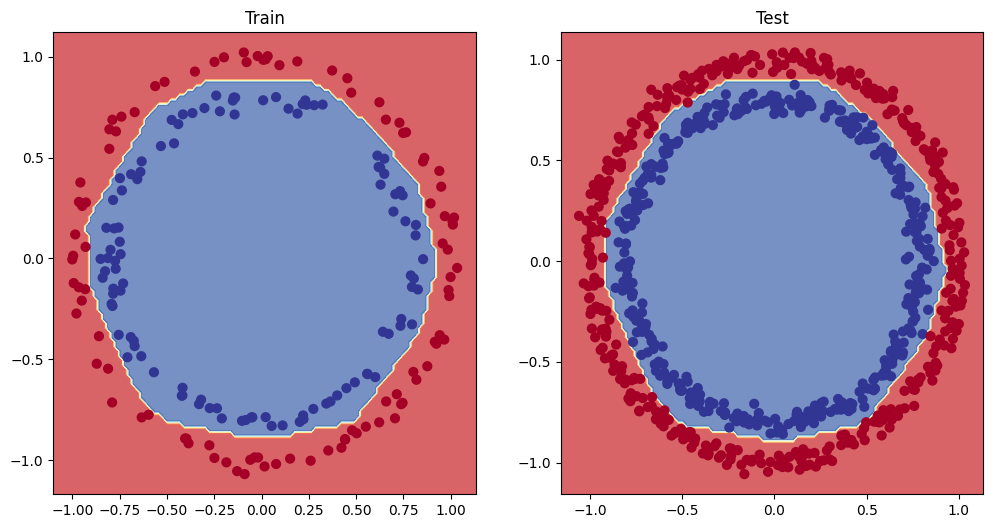

In [177]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## 7. Replicating non-linear layer

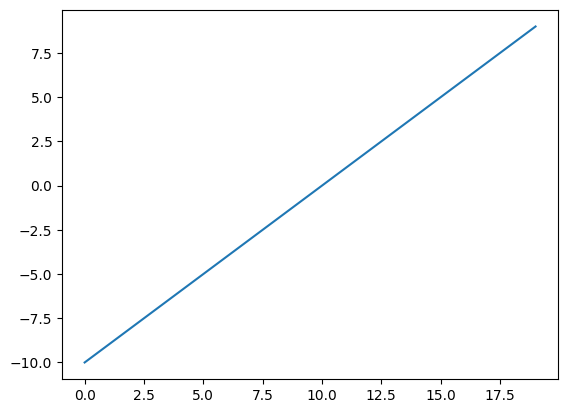

In [183]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

In [181]:
def relu(X: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), X)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

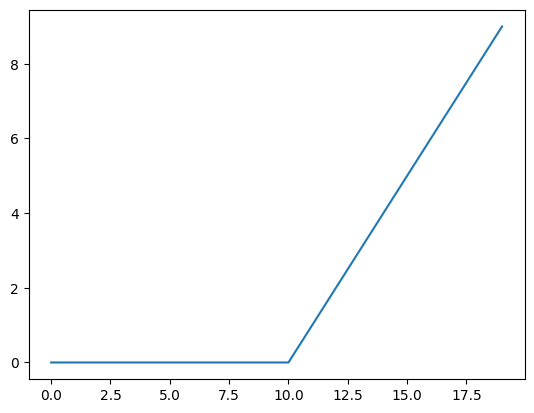

In [182]:
plt.plot(relu(A))

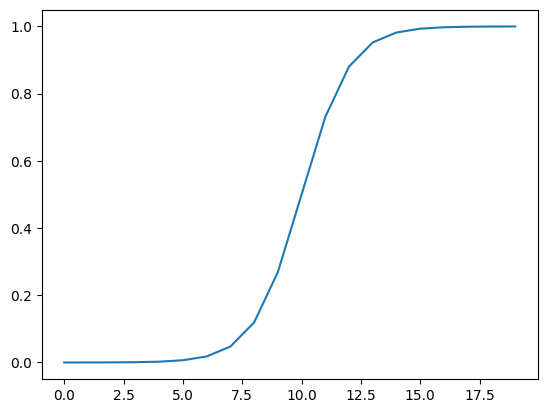

In [184]:
def sigmoid(X: torch.tensor) -> torch.tensor:
    return 1./(1. + torch.exp(-X))

plt.plot(sigmoid(A))